# Used Car Pricing Algorithm

## Environment

In [1]:
import numpy as np
import pandas as pd

In [2]:
# show 100 rows max
pd.options.display.max_rows = 100

## Load Data

In [3]:
def print_shape(df):
    print(f"Rows: {df.shape[0]:,} \nColumns: {df.shape[1]:,}")

In [4]:
def print_rows(df):
    print(f"Rows: {df.shape[0]:,}")

In [5]:
data_dir = "/data/p_dsi/capstone_projects/shea/4_merged/"
filename = "merged_structured.pkl"

df = pd.read_pickle(data_dir + filename)
print_shape(df)

Rows: 13,074,852 
Columns: 42


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13074852 entries, 0 to 13074851
Data columns (total 42 columns):
 #   Column               Dtype         
---  ------               -----         
 0   vin                  object        
 1   price                float64       
 2   miles                float64       
 3   year                 float64       
 4   make                 object        
 5   model                object        
 6   trim                 object        
 7   vehicle_type         object        
 8   body_type            object        
 9   body_subtype         object        
 10  drivetrain           object        
 11  fuel_type            object        
 12  engine_block         object        
 13  engine_size          object        
 14  transmission         object        
 15  doors                float64       
 16  cylinders            float64       
 17  city_mpg             float64       
 18  highway_mpg          float64       
 19  base_exterior_color

Title registration is the source of truth for purchase date and price. Listing for everything else...

## Business Case Exclusions

### Consumer Cars and Trucks Only
Exclude commerical and recreational vehicles

In [7]:
# consumer cars and trucks
# df["body_type"].value_counts()

excluded_vehtypes = ["Cargo Van","Passenger Van","Chassis Cab","Car Van"
                     ,"Combi","Cutaway","Van","Commercial Wagon","Chassis Cowl"]

print(df["body_type"].isin(excluded_vehtypes).sum())
df = df[~df["body_type"].isin(excluded_vehtypes)]
print_shape(df)

135385
Rows: 12,939,467 
Columns: 42


In [ ]:
# body subtype

### Not Vintage
Vehicles older than 20 years can qualify for an antique plate

In [8]:
# replace missing model year in listing with model year from mvr/registration
df.loc[df["year"].isna(),"year"] = df.loc[df["year"].isna(),"mvr_model_year"]
df["year"] = df["year"].astype("int") # convert to int

In [9]:
# drop missing purchase date
print(df["mvr_purchase_date"].isna().sum())
df = df[~(df["mvr_purchase_date"].isna())]
print_rows(df)

160
Rows: 12,939,307


In [10]:
# drop purchase date pre-2017
print((df["mvr_purchase_date"] < pd.to_datetime('20170101', format='%Y%m%d')).sum())
df = df[~(df["mvr_purchase_date"] < pd.to_datetime('20170101', format='%Y%m%d'))]
print_rows(df)

19466
Rows: 12,919,841


In [11]:
# difference between purchase date and 01-01-model_year
df["timedelta"] = df["mvr_purchase_date"] - pd.to_datetime(df['year'].astype(str) + '0101', format='%Y%m%d')

In [12]:
# compute age in months
df["age_months"] = np.round(df['timedelta'].astype('timedelta64[s]') / (30.44*24*60*60)).astype(int)
df["age_months"] = df["age_months"] + 6 # model year release date factor

In [13]:
# drop 20+ years old
print((df["age_months"] >= 240).sum())
df = df[df["age_months"] < 240]
print_rows(df)

166858
Rows: 12,752,983


In [14]:
# drop problematic negative age
print((df["age_months"] < 1).sum())
df = df[~(df["age_months"] < 1)]
print_rows(df)

6025
Rows: 12,746,958


### International

In [15]:
# canadians/mexicans
print((df["currency_indicator"] == "CAD").sum())
df = df[~(df["currency_indicator"] == "CAD")]

print((df["miles_indicator"] == "KILOMETERS").sum())
df = df[~(df["miles_indicator"] == "KILOMETERS")]


44
373


## Fatally Missing Values
Not appropriate to impute these since they're too important

### Price

In [16]:
# price missing
print(df["mvr_price"].isna().sum())
df = df[~df["mvr_price"].isna()]
print_rows(df)

939639
Rows: 11,806,902


In [17]:
# price ~ 0
print((df["mvr_price"] < 10).sum())
df = df[~(df["mvr_price"] < 10)]
print_rows(df)

2659751
Rows: 9,147,151


### Mileage

In [18]:
# replace missing listing miles with registration miles
df.loc[df["miles"].isna(),"miles"] = pd.to_numeric(df['mvr_mileage'], errors='coerce')[df["miles"].isna()]

In [19]:
# replace 0 listing miles with registration miles
df.loc[(df["miles"] == 0),"miles"] = pd.to_numeric(df['mvr_mileage'], errors='coerce')[df["miles"] == 0]

In [20]:
# drop if miles
print(df["miles"].isna().sum())
print((df["miles"] == 0).sum())
df = df[~(df["miles"].isna() | (df["miles"] == 0))]
print_rows(df)

32339
5940
Rows: 9,108,872


## Suspicious Data

### Listing Date vs Purchase Date

In [21]:
# difference between the last listing and the sale date recorded on the state registration
#df["list_sale_diff"] = (df['mvr_purchase_date'] - df['status_date']).astype('timedelta64[D]')
#print_shape(df)
# drop na's
#df.dropna(subset=["list_sale_diff"], inplace=True)
#print_shape(df)
# keep records with difference less than 90 days
#df = df[abs(df["list_sale_diff"]) < 90]
#print_shape(df)
#(abs(df["list_sale_diff"]) > 90).sum()

### Mileage

In [22]:
# TODO: Check high mileage against mvr mileage

In [23]:
# calculate high and low prices
top = df["miles"].quantile(0.999)
print(round(top))
bottom = df["miles"].quantile(0.001)
print(round(bottom))

300789
4


In [24]:
toptop = df["miles"].quantile(0.9999)
print(toptop)

610699.980498122


### Other Strange Values

In [25]:
df = df[df["drivetrain"].isin(["FWD", "RWD", "4WD"])]

In [26]:
mapping = {"Lpg / Natural Gas":"Natural Gas"
           ,"Unleaded / Premium Unleaded":"Premium Unleaded"
           ,"E85; Unleaded ":"E85 / Unleaded"
           ,"E85 / Unleaded; Premium Unleaded":"Premium Unleaded"
           ,"Compressed Natural Gas; Unleaded":"Natural Gas"
           ,"Unleaded; Unleaded / E85":"E85 / Unleaded"
           ,"E85 / Unleaded; Unleaded / E85 ":"E85 / Unleaded"
           ,"Unleaded / Electric":"Electric / Unleaded"
           ,"Compressed Natural Gas / Unleaded":"Natural Gas"
           ,"Premium Unleaded; Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded / Unleaded":"E85 / Unleaded"
           ,"Compressed Natural Gas":"Natural Gas"
           ,"Unleaded / Unleaded":"Unleaded"
           ,"Premium Unleaded / Unleaded":"Premium Unleaded"
           ,"E85 / Unleaded; Unleaded":"E85 / Unleaded"
           ,"Unleaded / E85":"E85 / Unleaded"
          }

df['fuel_type'] = df['fuel_type'].map(mapping).fillna(df['fuel_type'])

In [27]:
df['zip'] = df['zip'].str[:5]

## Make, Model, Trim
Central to target encoding. Need at least 1000 observations of make/model/trim combo

In [28]:
# make, model, or trim is null
print((df["make"].isna() | df["model"].isna() | df["trim"].isna()).sum())
df = df[~(df["make"].isna() | df["model"].isna() | df["trim"].isna())]
print_rows(df)

3146
Rows: 9,030,990


In [29]:
# new make/model/trim col
df['make_model_trim'] = df['make'] + ' / ' + df['model'] + ' / ' + df['trim']

In [30]:
# drop make/model/trim <100 obs
print(sum(df["make_model_trim"].value_counts()[df["make_model_trim"].value_counts() < 1000]))
df = df[~df['make_model_trim'].isin(list((df["make_model_trim"].value_counts()[df["make_model_trim"].value_counts() < 1000]).index))]
print_rows(df)

843256
Rows: 8,187,734


In [108]:
df["make_model_trim"].nunique()

1229

## Target Variable

We're not sellin' Ferraris and Lamborghinis here. We're sellin' everyday used cars.

In [31]:
df["mvr_price"].describe()

count    8.187734e+06
mean     2.138965e+05
std      3.472267e+08
min      1.000000e+01
25%      1.371900e+04
50%      2.085000e+04
75%      3.038600e+04
max      7.911790e+11
Name: mvr_price, dtype: float64

In [32]:
# calculate high and low prices
top = df["mvr_price"].quantile(0.999)
print(round(top))
bottom = df["mvr_price"].quantile(0.001)
print(round(bottom))

102755
100


In [33]:
toptop = df["mvr_price"].quantile(0.9999)
print(toptop)

215000.0


In [34]:
#df[(df["mvr_price"] > toptop)].sort_values(by=["mvr_price"])

Based on manual inspection, records with `mvr_price` over $300,000 become highly error-prone. Extensive data validation is beyond the scope of this project, and these records will be dumped.

In [35]:
# remove obvious data errors only
df = df[~(df["mvr_price"] > 300000)]

<AxesSubplot:>

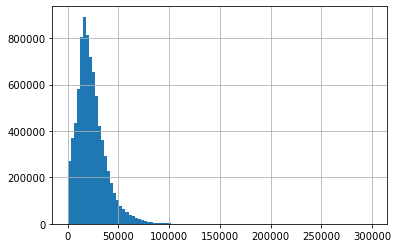

In [36]:
# plot distribution of mvr_price
df["mvr_price"].hist(bins=100)

## Subset Columns

In [37]:
df = df[['mvr_price','make_model_trim','miles', 'year','age_months', 'mvr_purchase_date',
       'vehicle_type', 'body_type', 'drivetrain', 'fuel_type',
       'engine_block', 'engine_size', 'transmission', 'doors', 'cylinders',
       'city_mpg', 'highway_mpg', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'zip','mvr_state',
       'hvf_standard', 'hvf_optional','make','model','trim']]

# numeric
df["engine_size"] = df["engine_size"].astype("float")

## Additional Feature Engineering

In [38]:
# purchase month
df["mvr_purchase_month"] = df["mvr_purchase_date"].dt.month.astype("category")

In [39]:
# monthly mileage
df["monthly_mileage"] = round(df["miles"]/df["age_months"],1)

In [40]:
# epa weights city/highway 55/45
df["mpg"] = df["city_mpg"] * 0.55 + df["highway_mpg"] * 0.45
df.drop(columns=["city_mpg", "highway_mpg"], inplace=True)

### Local Features

In [41]:
from uszipcode import SearchEngine
search = SearchEngine(simple_or_comprehensive=SearchEngine.SimpleOrComprehensiveArgEnum.comprehensive) 

In [42]:
def get_population_density_and_income(zipcode):
    result = search.by_zipcode(zipcode)
    if result:
        return pd.Series([result.population_density
                          ,result.median_household_income
                          ,result.median_home_value
                         ])
    else:
        return pd.Series([None, None, None])

In [43]:
# apply get_population_density_and_income to each value in zip_list
zip_list = pd.DataFrame(df['zip'].unique(), columns=['zip'])
zip_list[['population_density', 'median_income', 'median_home_value']] = zip_list['zip'].apply(get_population_density_and_income)
df = df.merge(zip_list, on='zip', how='left')

### Economic

In [44]:
df["mvr_purchase_yearmonth"] = df["mvr_purchase_date"].dt.strftime('%Y-%m')

In [45]:
# federal reserve economic data (fred)
from fredapi import Fred
fred = Fred(api_key_file='private/fred_api_key.txt')

#### Used Car Price Index

In [46]:
# BLS: Used cars and trucks in U.S. city average
used_car_price_index = fred.get_series('CUUR0000SETA02')
used_car_price_index.name = "used_car_price_index"
used_car_price_index.index = used_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
used_car_price_index.index = used_car_price_index.index.strftime('%Y-%m')
df = df.join(used_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### New Car Price Index

In [47]:
# BLS: New cars and trucks in U.S. city average
new_car_price_index = fred.get_series('CUSR0000SETA01')
new_car_price_index.name = "new_car_price_index"
new_car_price_index.index = new_car_price_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
new_car_price_index.index = new_car_price_index.index.strftime('%Y-%m')
df = df.join(new_car_price_index, on="mvr_purchase_yearmonth", how="left")

#### Gas Prices

In [48]:
gas_price_index = fred.get_series('GASREGW')
gas_price_index.name = "gas_price_index"
gas_price_index = gas_price_index.groupby(pd.Grouper(freq='M')).mean().resample('M').mean()
gas_price_index.index = gas_price_index.index + pd.DateOffset(months=1) # shift index 
gas_price_index.index = gas_price_index.index.strftime('%Y-%m')
df = df.join(gas_price_index, on="mvr_purchase_yearmonth", how="left")

#### Consumer Sentiment

In [49]:
consumer_sentiment_index = fred.get_series('UMCSENT')
consumer_sentiment_index.name = "consumer_sentiment_index"
consumer_sentiment_index.index = consumer_sentiment_index.index + pd.DateOffset(months=1) # shift index (have to use last month's index to predict next month's price)
consumer_sentiment_index.index = consumer_sentiment_index.index.strftime('%Y-%m')
df = df.join(consumer_sentiment_index, on="mvr_purchase_yearmonth", how="left")

### "High Value Features" Vehicle Options

In [50]:
def make_series(x):
    return pd.Series(x, dtype = object)

In [51]:
from tqdm import tqdm
tqdm.pandas()

In [52]:
hvf_optional = df["hvf_optional"]

In [53]:
hvf_optional_df = pd.get_dummies(hvf_optional.progress_apply(make_series).stack()).groupby(level=0).sum()
print(hvf_optional_df.shape)

100%|██████████| 8187531/8187531 [39:47<00:00, 3428.65it/s]  


(2945839, 77)


In [54]:
merged_df = df.join(hvf_optional_df, how="left")
hvf_cols = list(hvf_optional_df.columns)
merged_df[hvf_cols] = merged_df[hvf_cols].fillna(0)
print_shape(merged_df)

Rows: 8,187,531 
Columns: 113


In [55]:
df = merged_df

In [56]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
df.to_pickle(working_dir + "df.pkl")

## Data Split

In [ ]:
working_dir = "/data/p_dsi/capstone_projects/shea/working/"
df = pd.read_pickle(working_dir + "df.pkl")

In [57]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# shuffle dataframe for good measure
df = df.sample(frac=1).reset_index(drop=True)

# create StratifiedShuffleSplit object by make_model_trim column
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_index, temp_index = next(sss.split(df, df['make_model_trim']))

# create StratifiedShuffleSplit object by make_model_trim column again
df_temp = df.loc[temp_index]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
val_index, test_index = next(sss.split(df_temp, df_temp['make_model_trim']))

# split dataframe into train, validate, and test sets
train = df.loc[train_index]
validate = df.loc[temp_index[val_index]]
test = df.loc[temp_index[test_index]]

print("Train")
print_rows(train)
print("\nValidate")
print_rows(validate)
print("\nTest")
print_rows(test)


Train
Rows: 5,731,271

Validate
Rows: 1,645,694

Test
Rows: 810,566


## Target Encoding

In [58]:
train["make_model_trim_encoded"] = train["make_model_trim"]
validate["make_model_trim_encoded"] = validate["make_model_trim"]
test["make_model_trim_encoded"] = test["make_model_trim"]

In [59]:
# fit encoder
import category_encoders as ce

encoder = ce.TargetEncoder(cols=['make_model_trim_encoded'])
encoder.fit(train, train["mvr_price"])

TargetEncoder(cols=['make_model_trim_encoded'])

In [60]:
# transform
train = encoder.transform(train)
validate = encoder.transform(train)
test = encoder.transform(train)

## HVF Dimsionality Reduction

In [61]:
hvf_cols = ['3rd Row Seats',  '4-Wheel Steering',  'Adaptive Cruise Control', 'Android Auto',
 'Anti Collision System', 'Apple CarPlay', 'Automatic Transmission', 'Autonomous Drive Functions',
 'Aux Jack Input', 'Backup Camera', 'Biodiesel', 'Blind Spot System', 'Bluetooth', 'Brake Assist',
 'CVT Transmission', 'Collision/Breakdown Telematics', 'Coming Home Device',
 'Compressed Natural Gas', 'Concierge Services', 'Convertible Roof', 'Cruise Control', 'Diesel',
 'Directional Headlights', 'Dual Rear Wheels', 'Dynamic Steering', 'Electric', 'Fog Lights',
 'Gasoline', 'HDMI Connection', 'Hands Free Liftgate', 'Heads Up Display', 'Heated Door Mirrors',
 'Heated Seats', 'Heated/Cooled Seats', 'Hybrid', 'Keyless Entry/Locking', 'Keyless Start/Remote Engine Start',
 'LPG', 'Lane Keep Assist', 'Leather Seats', 'Leatherette Seats', 'Manual Transmission', 'Massage Seats',
 'Memory Mirrors', 'Memory Seats', 'Memory Steering Wheel Position', 'Mirrorlink', 'Navigation',
 'Panoramic Sun/Moonroof', 'Parking Assistance', 'Parking Distance Sensors', 'Parking Radar',
 'Parking distance system', 'Phone Integration', 'Pickup Bed Cover', 'Pickup Bed Extender', 'Pickup Bed Liner',
 'Power Closing Doors', 'Power Closing Liftgate', 'Premium Audio', 'Premium Cup Holders', 'Premium Wheels',
 'Rear/Multi-Zone Air Conditioning', 'Satellite Radio', 'Steering Wheel Controls', 'Sun/Moonroof',
 'Touch Screen', 'Touch Screen Audio', 'Trailer Assist', 'Trailer Tow Mirrors', 'Turbo Boost',
 'USB Connection', 'Video Entertainment', 'Voice Recognision', 'Voice Recognition', 'WiFi Hotspot',
            'Wireless Charging/Connection']

In [64]:
from sklearn.decomposition import PCA

def reduce_hvf(df,hvf_cols,pca=None):
    subset_df = df[hvf_cols]
    
    # compute pca if not provided
    if not pca:
        pca = PCA(n_components=9)
        pca.fit(subset_df)
    
    transformed_subset = pca.transform(subset_df)
    transformed_subset = pd.DataFrame(transformed_subset, columns=['hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3'
                                                                ,'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6'
                                                                ,'hvf_comp_7', 'hvf_comp_8', 'hvf_comp_9'
                                                                #,'hvf_comp_10', 'hvf_comp_11', 'hvf_comp_12'
                                                                #,'hvf_comp_13', 'hvf_comp_14', 'hvf_comp_15'
                                                                #,'hvf_comp_16'
                                                                  ])
    transformed_subset.index = df.index
    final_df = pd.concat([df.drop(columns=hvf_cols),transformed_subset], axis=1,ignore_index=False)
    print_shape(final_df)
    return final_df,pca

In [65]:
train,pca_train = reduce_hvf(train,hvf_cols)

Rows: 5,731,271 
Columns: 46


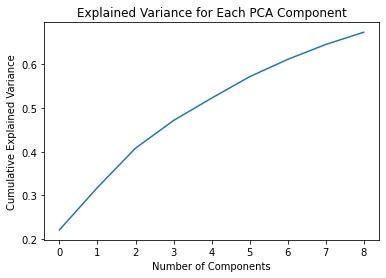

In [71]:
import matplotlib.pyplot as plt

# plot the explained variance for each component
plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance for Each PCA Component')
plt.show()

#loadings = pd.DataFrame(pca.components_.T, index=test_hvf.columns)
#for component in loadings.columns:
#    print(f'Top 5 loadings for {component}:')
#    print(loadings[component].abs().sort_values(ascending=False)[:5])
#    print('\n')


In [72]:
validate,_ = reduce_hvf(validate,hvf_cols,pca_train)

Rows: 5,731,271 
Columns: 46


In [73]:
test,_ = reduce_hvf(test,hvf_cols,pca_train)

Rows: 5,731,271 
Columns: 46


## Missing

In [74]:
# calculate percent missing for each field in df
def percent_missing(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    # Sort the table by percentage of missing descending
    mis_val_table = (
        mis_val_table[mis_val_table.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    # Print some summary information
    print(f"{mis_val_table.shape[0]} of {df.shape[1]} columns have missing values")
    # Return the dataframe with missing information
    return mis_val_table


In [75]:
# check for missing
print(percent_missing(train))
print(percent_missing(validate))
print(percent_missing(test))

18 of 46 columns have missing values
                     Missing Values  % of Total Values
hvf_optional                3669724               64.0
base_interior_color         1447499               25.3
is_certified                1250946               21.8
hvf_standard                1143451               20.0
base_exterior_color          520748                9.1
engine_block                 400142                7.0
cylinders                    400142                7.0
engine_size                  398316                6.9
mpg                          313777                5.5
median_income                 42049                0.7
population_density            42049                0.7
median_home_value             42049                0.7
transmission                   3031                0.1
vehicle_type                   1065                0.0
fuel_type                       669                0.0
doors                           668                0.0
body_type                   

### Simple Handling

In [76]:
# certified
train["is_certified"].fillna(0, inplace=True)
validate["is_certified"].fillna(0, inplace=True)
test["is_certified"].fillna(0, inplace=True)

In [77]:
# location info missing
train = train[~train["zip"].isna()]
validate = validate[~validate["zip"].isna()]
test = test[~test["zip"].isna()]

### Impute Mode for Categoricals

In [78]:
# categoricals
categoricals = ["base_interior_color","base_exterior_color","engine_block"
                ,"transmission","vehicle_type","fuel_type","body_type"
                ,"drivetrain"]
group = 'make_model_trim'
for cat in categoricals:
    train[cat] = train.groupby(group)[cat].transform(lambda x: x.fillna(x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'))
    validate[cat] = validate[group].map(train.groupby(group)[cat].apply(lambda x: x.mode()[0]))
    test[cat] = test[group].map(train.groupby(group)[cat].apply(lambda x: x.mode()[0]))

### Impute Median for Numerics

In [79]:
# numerics
numerics = ["cylinders","engine_size","mpg","doors"]
groups = ["make_model_trim","engine_size","cylinders","body_type"]
for group in groups:
    for num in numerics:
        train[num] = train.groupby(group)[num].transform(lambda x: x.fillna(x.median()))
        validate[num] = validate[group].map(train.groupby(group)[num].median())
        test[num] = test[group].map(train.groupby(group)[num].median())

### Impute Median for Zip Features

In [80]:
from sklearn.impute import SimpleImputer

# fit a median imputer on train
imputer = SimpleImputer(strategy='median')
imputer.fit(train[['population_density', 'median_income', 'median_home_value']])

# apply the median impute
train[['population_density', 'median_income', 'median_home_value']] = imputer.transform(train[['population_density', 'median_income', 'median_home_value']])
validate[['population_density', 'median_income', 'median_home_value']] = imputer.transform(validate[['population_density', 'median_income', 'median_home_value']])
test[['population_density', 'median_income', 'median_home_value']] = imputer.transform(test[['population_density', 'median_income', 'median_home_value']])


In [81]:
# check for missing
print(percent_missing(train))
print(percent_missing(validate))
print(percent_missing(test))

2 of 46 columns have missing values
              Missing Values  % of Total Values
hvf_optional         3669592               64.0
hvf_standard         1143409               20.0
2 of 46 columns have missing values
              Missing Values  % of Total Values
hvf_optional         3669592               64.0
hvf_standard         1143409               20.0
2 of 46 columns have missing values
              Missing Values  % of Total Values
hvf_optional         3669592               64.0
hvf_standard         1143409               20.0


## EDA

In [82]:
train.columns

Index(['mvr_price', 'make_model_trim', 'miles', 'year', 'age_months',
       'mvr_purchase_date', 'vehicle_type', 'body_type', 'drivetrain',
       'fuel_type', 'engine_block', 'engine_size', 'transmission', 'doors',
       'cylinders', 'base_exterior_color', 'base_interior_color',
       'is_certified', 'zip', 'mvr_state', 'hvf_standard', 'hvf_optional',
       'make', 'model', 'trim', 'mvr_purchase_month', 'monthly_mileage', 'mpg',
       'population_density', 'median_income', 'median_home_value',
       'mvr_purchase_yearmonth', 'used_car_price_index', 'new_car_price_index',
       'gas_price_index', 'consumer_sentiment_index',
       'make_model_trim_encoded', 'hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3',
       'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6', 'hvf_comp_7', 'hvf_comp_8',
       'hvf_comp_9'],
      dtype='object')

In [83]:
# numerics correlations with target
correlations = train.corr(method="pearson", numeric_only=True)["mvr_price"].sort_values(ascending=False)
correlations

mvr_price                   1.000000
make_model_trim_encoded     0.787045
year                        0.615130
engine_size                 0.419075
cylinders                   0.386631
hvf_comp_1                  0.283403
used_car_price_index        0.173594
new_car_price_index         0.164485
gas_price_index             0.160161
is_certified                0.144777
hvf_comp_4                  0.114666
median_income               0.089219
median_home_value           0.084965
hvf_comp_9                  0.074301
monthly_mileage             0.058452
hvf_comp_6                  0.030634
hvf_comp_7                  0.026195
doors                       0.010913
hvf_comp_2                 -0.014507
hvf_comp_8                 -0.018819
hvf_comp_5                 -0.019920
population_density         -0.024859
hvf_comp_3                 -0.031557
consumer_sentiment_index   -0.137772
mpg                        -0.319904
miles                      -0.483133
age_months                 -0.562934
N

engine_size       AxesSubplot(0.125,0.125;0.227941x0.755)
miles          AxesSubplot(0.398529,0.125;0.227941x0.755)
age_months     AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

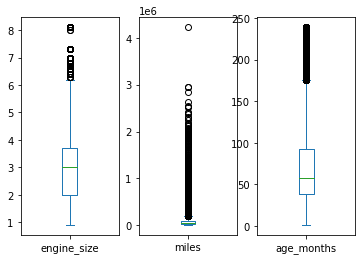

In [105]:
# boxplots of numeric variables
train[[
 'engine_size',
 'miles',
 'age_months']].plot(kind='box', subplots=True, layout=(1,3), sharex=False, sharey=False)

/tmp/ipykernel_190117/4258576343.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


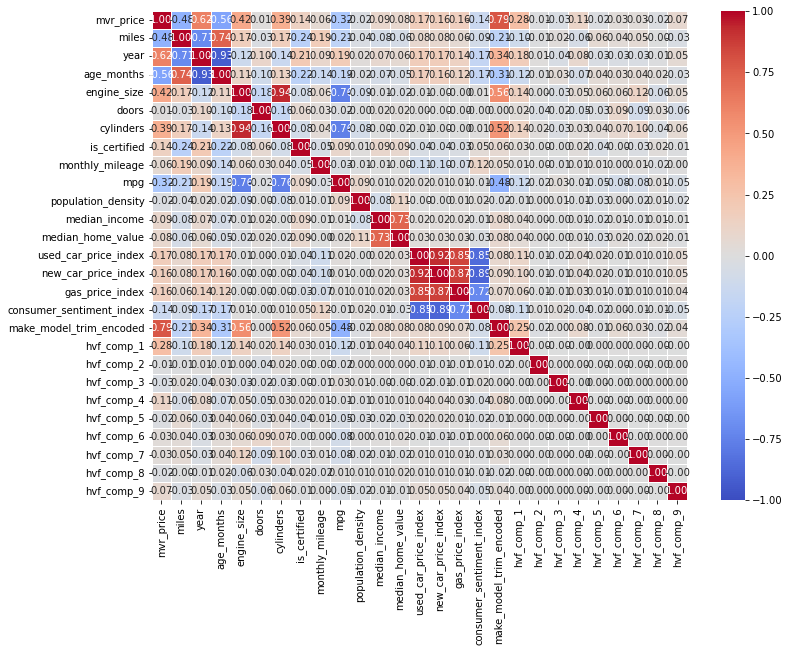

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = train.corr()

plt.figure(figsize=(12, 9))

sns.heatmap(
    corr_matrix,
    annot=True,       # Display the correlation coefficients
    fmt=".2f",        # Format the correlation coefficients to 2 decimal places
    cmap="coolwarm",  # Choose a color palette for the heatmap
    vmin=-1,          # Set the minimum value for the color scale
    vmax=1,           # Set the maximum value for the color scale
    linewidths=.5,    # Add a small space between the cells for better readability
)

# Display the heatmap
plt.show()


## Pre-Modeling EDA

In [85]:
print_shape(train)
train.sample(5).T


Rows: 5,731,076 
Columns: 46


,7752074,6456647,2586345,2596605,7475406
mvr_price,11595.0,7098.0,37453.0,29799.0,13295.0
make_model_trim,Chrysler / 200 / Limited,Chevrolet / Sonic / 2LT,GMC / Terrain / SLT,GMC / Sierra 1500 / SLE,BMW / 3 Series / 328i
miles,58587.0,70001.0,9108.0,55384.0,60555.0
year,2015,2012,2021,2015,2014
age_months,49,79,21,79,80
mvr_purchase_date,2018-07-20 00:00:00,2018-01-29 00:00:00,2022-04-11 00:00:00,2021-02-09 00:00:00,2020-03-09 00:00:00
vehicle_type,Car,Car,Truck,Truck,Car
body_type,Sedan,Hatchback,SUV,Pickup,Sedan
drivetrain,FWD,FWD,FWD,RWD,4WD
fuel_type,Unleaded,Unleaded,Unleaded,Unleaded,Premium Unleaded


## Model

In [86]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def assess_results(y_test, y_pred):
    print("R2: ", round(r2_score(y_test, y_pred),3))
    print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
    print("MAPE: ", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,1),"%")
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print("Percent Underpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) >= 0]) / len(y_test) * 100,1),"%")
    print("Mean of Underpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) > 0]),2))
    print("Percent Overpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) < 0]) / len(y_test) * 100,1),"%")
    print("Mean of Overpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) < 0]),2))
    print("Mean Error: ", round(np.mean(y_test - y_pred),2)) 
    

### Column Inventory

In [87]:
# numeric columns
num_cols = list(correlations.index)
num_cols.sort()
num_cols.remove("year")
num_cols.remove("mvr_price")
num_cols

['age_months',
 'consumer_sentiment_index',
 'cylinders',
 'doors',
 'engine_size',
 'gas_price_index',
 'hvf_comp_1',
 'hvf_comp_2',
 'hvf_comp_3',
 'hvf_comp_4',
 'hvf_comp_5',
 'hvf_comp_6',
 'hvf_comp_7',
 'hvf_comp_8',
 'hvf_comp_9',
 'is_certified',
 'make_model_trim_encoded',
 'median_home_value',
 'median_income',
 'miles',
 'monthly_mileage',
 'mpg',
 'new_car_price_index',
 'population_density',
 'used_car_price_index']

In [88]:
cat_cols = list(train.columns)

# remove num cols
for num_col in num_cols:
    cat_cols.remove(num_col)

# remove selected other cols
other_cols = ["hvf_optional","hvf_standard","mvr_purchase_date","mvr_purchase_yearmonth","zip","year"]
for other_col in other_cols:
    cat_cols.remove(other_col)

# remove target and cleanup
cat_cols.remove("mvr_price")
cat_cols.sort()
cat_cols

['base_exterior_color',
 'base_interior_color',
 'body_type',
 'drivetrain',
 'engine_block',
 'fuel_type',
 'make',
 'make_model_trim',
 'model',
 'mvr_purchase_month',
 'mvr_state',
 'transmission',
 'trim',
 'vehicle_type']

In [89]:
target = "mvr_price"

### Feature Prep

In [90]:
train_backup = train.copy()
validate_backup = validate.copy()
test_backup = test.copy()

In [91]:
# scale numeric columns
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

# fit
#scaler.fit(train[num_cols])


In [92]:
# transform
#train[num_cols] = scaler.transform(train[num_cols])
#validate[num_cols] = scaler.transform(validate[num_cols])
#test[num_cols] = scaler.transform(test[num_cols])

In [93]:
train[num_cols].sample(5).T

,6897727,4400721,3532649,7709838,2570501
age_months,49.000000,16.000000,65.000000,15.000000,77.000000
consumer_sentiment_index,81.200000,59.900000,76.900000,58.600000,56.800000
cylinders,8.000000,4.000000,8.000000,6.000000,4.000000
doors,4.000000,5.000000,5.000000,4.000000,4.000000
engine_size,6.700000,2.000000,5.700000,3.500000,1.500000
gas_price_index,3.136000,3.815200,2.108200,3.700250,3.685000
hvf_comp_1,-0.300058,-0.211599,0.313175,1.348424,-0.302905
hvf_comp_2,0.028215,0.030820,-0.006042,0.941952,0.014306
hvf_comp_3,-0.012657,-0.031849,-0.187550,-1.581622,0.057039
hvf_comp_4,0.071097,0.044864,0.992454,0.499385,0.005843


### Linear

In [94]:
from sklearn.linear_model import LinearRegression

In [95]:
# box-cox transform mvr_price
#from scipy import stats
#train["mvr_price_bc"], bc_lambda = stats.boxcox(train["mvr_price"])
#train["mvr_price_bc"].hist(bins=100)

In [96]:
# fit
lr_model = LinearRegression()
lr_model.fit(train[num_cols], train[target])

# predict
lr_preds = lr_model.predict(validate[num_cols])

# results
assess_results(validate[target], lr_preds)

R2:  0.493
MAE:  7138.78
MAPE:  77.6 %
RMSE:  10419.73
Percent Underpayed:  38.0 %
Mean of Underpayment:  9284.3
Percent Overpayed:  62.0 %
Mean of Overpayment:  -5823.35
Mean Error:  -81.23


In [97]:
# coefficients
coef_df = pd.DataFrame({'feature_name': train[num_cols].columns, 'coefficient': lr_model.coef_})
print(coef_df)

                feature_name  coefficient
0                 age_months   -95.272983
1   consumer_sentiment_index    13.145175
2                  cylinders   269.810314
3                      doors     6.416325
4                engine_size  1335.215312
5            gas_price_index   520.121337
6                 hvf_comp_1  1043.532767
7                 hvf_comp_2  -320.007739
8                 hvf_comp_3  -298.355132
9                 hvf_comp_4  1009.831530
10                hvf_comp_5  -206.620338
11                hvf_comp_6   278.424515
12                hvf_comp_7   319.706998
13                hvf_comp_8   274.665515
14                hvf_comp_9   991.381871
15              is_certified  1001.382782
16   make_model_trim_encoded     0.639868
17         median_home_value     0.002984
18             median_income    -0.003198
19                     miles    -0.059470
20           monthly_mileage     0.438045
21                       mpg  -118.101851
22       new_car_price_index    11

### CatBoost

In [98]:
from catboost import CatBoostRegressor

In [99]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = []
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

['age_months',
 'consumer_sentiment_index',
 'cylinders',
 'doors',
 'engine_size',
 'gas_price_index',
 'hvf_comp_1',
 'hvf_comp_2',
 'hvf_comp_3',
 'hvf_comp_4',
 'hvf_comp_5',
 'hvf_comp_6',
 'hvf_comp_7',
 'hvf_comp_8',
 'hvf_comp_9',
 'is_certified',
 'make_model_trim_encoded',
 'median_home_value',
 'median_income',
 'miles',
 'monthly_mileage',
 'mpg',
 'new_car_price_index',
 'population_density',
 'used_car_price_index']

In [100]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

['base_exterior_color',
 'base_interior_color',
 'body_type',
 'drivetrain',
 'engine_block',
 'fuel_type',
 'mvr_purchase_month',
 'mvr_state',
 'transmission',
 'vehicle_type']

In [101]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=True)
cb_model.fit(train[selected_num_cols + selected_cat_cols]
             ,train[target]
             ,eval_set=(validate[num_cols + cat_cols], validate[target])
            )

Learning rate set to 0.198125
0:	learn: 12608.2239827	test: 14037.7794116	best: 14037.7794116 (0)	total: 4.57s	remaining: 1h 16m 6s
1:	learn: 11046.7952275	test: 13530.4600712	best: 13530.4600712 (1)	total: 8.97s	remaining: 1h 14m 36s
2:	learn: 9839.2011238	test: 13219.0448336	best: 13219.0448336 (2)	total: 12.8s	remaining: 1h 10m 55s
3:	learn: 8865.6053505	test: 12549.1906415	best: 12549.1906415 (3)	total: 16.8s	remaining: 1h 9m 41s
4:	learn: 8120.0940861	test: 12157.4533653	best: 12157.4533653 (4)	total: 20.7s	remaining: 1h 8m 40s
5:	learn: 7558.9959500	test: 11753.4090080	best: 11753.4090080 (5)	total: 25.5s	remaining: 1h 10m 18s
6:	learn: 7116.9220847	test: 11626.9244678	best: 11626.9244678 (6)	total: 29.5s	remaining: 1h 9m 38s
7:	learn: 6761.3886776	test: 11407.2040126	best: 11407.2040126 (7)	total: 33.5s	remaining: 1h 9m 18s
8:	learn: 6507.3801663	test: 11160.3255816	best: 11160.3255816 (8)	total: 38.2s	remaining: 1h 10m 1s
9:	learn: 6264.7272931	test: 11019.1538176	best: 11019.1

81:	learn: 4593.7032809	test: 9010.2628905	best: 9008.9251254 (80)	total: 5m 24s	remaining: 1h 34s
82:	learn: 4591.0544799	test: 9009.6028110	best: 9008.9251254 (80)	total: 5m 28s	remaining: 1h 28s
83:	learn: 4583.9402665	test: 9002.6383520	best: 9002.6383520 (83)	total: 5m 32s	remaining: 1h 25s
84:	learn: 4579.3207450	test: 9000.5770169	best: 9000.5770169 (84)	total: 5m 35s	remaining: 1h 13s
85:	learn: 4572.7932890	test: 8997.1556993	best: 8997.1556993 (85)	total: 5m 39s	remaining: 1h 10s
86:	learn: 4570.2341311	test: 8986.7190592	best: 8986.7190592 (86)	total: 5m 43s	remaining: 1h 7s
87:	learn: 4565.3193123	test: 8990.6631874	best: 8986.7190592 (86)	total: 5m 47s	remaining: 1h 2s
88:	learn: 4562.6191803	test: 8990.5412832	best: 8986.7190592 (86)	total: 5m 51s	remaining: 59m 56s
89:	learn: 4559.3446877	test: 8986.4489385	best: 8986.4489385 (89)	total: 5m 55s	remaining: 59m 56s
90:	learn: 4555.7129030	test: 8984.4573041	best: 8984.4573041 (90)	total: 5m 59s	remaining: 59m 48s
91:	learn

163:	learn: 4309.1321842	test: 8885.6152203	best: 8869.1353725 (142)	total: 10m 39s	remaining: 54m 19s
164:	learn: 4306.7866117	test: 8885.6810744	best: 8869.1353725 (142)	total: 10m 43s	remaining: 54m 15s
165:	learn: 4302.6336253	test: 8882.1929927	best: 8869.1353725 (142)	total: 10m 46s	remaining: 54m 9s
166:	learn: 4299.9895841	test: 8881.3042116	best: 8869.1353725 (142)	total: 10m 50s	remaining: 54m 4s
167:	learn: 4296.4766572	test: 8882.2443468	best: 8869.1353725 (142)	total: 10m 54s	remaining: 54m
168:	learn: 4295.4241069	test: 8882.0753652	best: 8869.1353725 (142)	total: 10m 58s	remaining: 53m 57s
169:	learn: 4292.4608127	test: 8881.8736432	best: 8869.1353725 (142)	total: 11m 2s	remaining: 53m 54s
170:	learn: 4291.2647197	test: 8875.5504903	best: 8869.1353725 (142)	total: 11m 6s	remaining: 53m 49s
171:	learn: 4289.5552609	test: 8869.5450951	best: 8869.1353725 (142)	total: 11m 10s	remaining: 53m 45s
172:	learn: 4288.0557117	test: 8869.8509437	best: 8869.1353725 (142)	total: 11m 1

243:	learn: 4166.9850067	test: 8898.2873179	best: 8821.2740751 (200)	total: 15m 47s	remaining: 48m 55s
244:	learn: 4164.7980310	test: 8875.9056779	best: 8821.2740751 (200)	total: 15m 51s	remaining: 48m 50s
245:	learn: 4163.5943951	test: 8876.0256792	best: 8821.2740751 (200)	total: 15m 55s	remaining: 48m 47s
246:	learn: 4162.2520833	test: 8872.3096761	best: 8821.2740751 (200)	total: 15m 58s	remaining: 48m 43s
247:	learn: 4160.9516607	test: 8871.6693940	best: 8821.2740751 (200)	total: 16m 3s	remaining: 48m 41s
248:	learn: 4158.7993803	test: 8870.6597873	best: 8821.2740751 (200)	total: 16m 7s	remaining: 48m 39s
249:	learn: 4158.0579636	test: 8870.4208240	best: 8821.2740751 (200)	total: 16m 11s	remaining: 48m 34s
250:	learn: 4157.0508377	test: 8865.6037928	best: 8821.2740751 (200)	total: 16m 15s	remaining: 48m 31s
251:	learn: 4155.5691658	test: 8866.2083382	best: 8821.2740751 (200)	total: 16m 19s	remaining: 48m 26s
252:	learn: 4154.9431708	test: 8866.0640256	best: 8821.2740751 (200)	total:

323:	learn: 4080.8791246	test: 8827.9515116	best: 8821.2740751 (200)	total: 20m 56s	remaining: 43m 40s
324:	learn: 4079.9632067	test: 8826.4348598	best: 8821.2740751 (200)	total: 20m 59s	remaining: 43m 36s
325:	learn: 4079.3205019	test: 8827.1142172	best: 8821.2740751 (200)	total: 21m 3s	remaining: 43m 31s
326:	learn: 4078.2742169	test: 8825.3380909	best: 8821.2740751 (200)	total: 21m 6s	remaining: 43m 26s
327:	learn: 4076.3909589	test: 8833.9273370	best: 8821.2740751 (200)	total: 21m 10s	remaining: 43m 23s
328:	learn: 4075.7756585	test: 8833.8350617	best: 8821.2740751 (200)	total: 21m 14s	remaining: 43m 19s
329:	learn: 4075.2085838	test: 8833.3787565	best: 8821.2740751 (200)	total: 21m 18s	remaining: 43m 16s
330:	learn: 4074.0340629	test: 8832.2676701	best: 8821.2740751 (200)	total: 21m 22s	remaining: 43m 12s
331:	learn: 4072.0677886	test: 8829.8339240	best: 8821.2740751 (200)	total: 21m 26s	remaining: 43m 8s
332:	learn: 4070.8135319	test: 8828.6720241	best: 8821.2740751 (200)	total: 

403:	learn: 4014.9600701	test: 8810.2364352	best: 8810.2364352 (403)	total: 26m 7s	remaining: 38m 32s
404:	learn: 4013.5313773	test: 8810.3007013	best: 8810.2364352 (403)	total: 26m 11s	remaining: 38m 28s
405:	learn: 4012.9890152	test: 8809.9805275	best: 8809.9805275 (405)	total: 26m 14s	remaining: 38m 24s
406:	learn: 4012.5135256	test: 8809.6039535	best: 8809.6039535 (406)	total: 26m 19s	remaining: 38m 20s
407:	learn: 4011.4528570	test: 8812.0675828	best: 8809.6039535 (406)	total: 26m 22s	remaining: 38m 16s
408:	learn: 4010.5093530	test: 8811.2737434	best: 8809.6039535 (406)	total: 26m 26s	remaining: 38m 12s
409:	learn: 4009.7850086	test: 8812.5502630	best: 8809.6039535 (406)	total: 26m 30s	remaining: 38m 8s
410:	learn: 4009.2612199	test: 8810.8644183	best: 8809.6039535 (406)	total: 26m 33s	remaining: 38m 3s
411:	learn: 4007.6021138	test: 8811.9131160	best: 8809.6039535 (406)	total: 26m 37s	remaining: 38m
412:	learn: 4006.5308955	test: 8814.6879315	best: 8809.6039535 (406)	total: 26m 

483:	learn: 3959.7599663	test: 8771.9213448	best: 8771.9213448 (483)	total: 31m 2s	remaining: 33m 5s
484:	learn: 3959.2377122	test: 8771.2422057	best: 8771.2422057 (484)	total: 31m 5s	remaining: 33m 1s
485:	learn: 3958.7757842	test: 8770.9874158	best: 8770.9874158 (485)	total: 31m 9s	remaining: 32m 57s
486:	learn: 3958.2182454	test: 8771.1700888	best: 8770.9874158 (485)	total: 31m 13s	remaining: 32m 53s
487:	learn: 3957.6950901	test: 8771.1038277	best: 8770.9874158 (485)	total: 31m 16s	remaining: 32m 49s
488:	learn: 3956.8370636	test: 8770.4941382	best: 8770.4941382 (488)	total: 31m 20s	remaining: 32m 45s
489:	learn: 3956.4402841	test: 8770.4149961	best: 8770.4149961 (489)	total: 31m 24s	remaining: 32m 41s
490:	learn: 3954.7082137	test: 8766.2475383	best: 8766.2475383 (490)	total: 31m 28s	remaining: 32m 37s
491:	learn: 3954.1409799	test: 8766.7105449	best: 8766.2475383 (490)	total: 31m 31s	remaining: 32m 33s
492:	learn: 3953.0210057	test: 8766.3847587	best: 8766.2475383 (490)	total: 31

563:	learn: 3917.1225625	test: 8776.3653329	best: 8763.7992890 (502)	total: 35m 56s	remaining: 27m 46s
564:	learn: 3916.3518069	test: 8775.9925728	best: 8763.7992890 (502)	total: 35m 59s	remaining: 27m 42s
565:	learn: 3916.0722527	test: 8775.7083846	best: 8763.7992890 (502)	total: 36m 3s	remaining: 27m 38s
566:	learn: 3915.6100827	test: 8776.7239546	best: 8763.7992890 (502)	total: 36m 7s	remaining: 27m 35s
567:	learn: 3915.1039460	test: 8776.4638025	best: 8763.7992890 (502)	total: 36m 10s	remaining: 27m 31s
568:	learn: 3914.7353594	test: 8776.4539769	best: 8763.7992890 (502)	total: 36m 14s	remaining: 27m 26s
569:	learn: 3914.5313464	test: 8776.2413392	best: 8763.7992890 (502)	total: 36m 17s	remaining: 27m 23s
570:	learn: 3914.2394285	test: 8776.1216280	best: 8763.7992890 (502)	total: 36m 21s	remaining: 27m 19s
571:	learn: 3913.9603581	test: 8777.0251140	best: 8763.7992890 (502)	total: 36m 25s	remaining: 27m 15s
572:	learn: 3913.6669871	test: 8777.1941167	best: 8763.7992890 (502)	total:

643:	learn: 3882.1920279	test: 8750.2932757	best: 8750.2932757 (643)	total: 40m 52s	remaining: 22m 35s
644:	learn: 3881.9706348	test: 8750.1640569	best: 8750.1640569 (644)	total: 40m 55s	remaining: 22m 31s
645:	learn: 3881.4521269	test: 8749.6385334	best: 8749.6385334 (645)	total: 40m 59s	remaining: 22m 27s
646:	learn: 3881.2971580	test: 8749.5339488	best: 8749.5339488 (646)	total: 41m 3s	remaining: 22m 23s
647:	learn: 3880.9910868	test: 8749.7436223	best: 8749.5339488 (646)	total: 41m 6s	remaining: 22m 20s
648:	learn: 3880.6677633	test: 8750.6592518	best: 8749.5339488 (646)	total: 41m 10s	remaining: 22m 16s
649:	learn: 3880.5101537	test: 8750.5580134	best: 8749.5339488 (646)	total: 41m 14s	remaining: 22m 12s
650:	learn: 3880.2007551	test: 8749.2102870	best: 8749.2102870 (650)	total: 41m 17s	remaining: 22m 8s
651:	learn: 3879.8751254	test: 8748.8474403	best: 8748.8474403 (651)	total: 41m 21s	remaining: 22m 4s
652:	learn: 3879.4091530	test: 8748.7227372	best: 8748.7227372 (652)	total: 4

723:	learn: 3854.4354801	test: 8744.1372719	best: 8736.6961256 (713)	total: 45m 53s	remaining: 17m 29s
724:	learn: 3854.0923619	test: 8743.9390782	best: 8736.6961256 (713)	total: 45m 57s	remaining: 17m 26s
725:	learn: 3853.8920687	test: 8744.0683989	best: 8736.6961256 (713)	total: 46m 1s	remaining: 17m 22s
726:	learn: 3853.1096662	test: 8724.1459404	best: 8724.1459404 (726)	total: 46m 5s	remaining: 17m 18s
727:	learn: 3852.7496077	test: 8724.3777146	best: 8724.1459404 (726)	total: 46m 8s	remaining: 17m 14s
728:	learn: 3852.4887684	test: 8724.3114321	best: 8724.1459404 (726)	total: 46m 12s	remaining: 17m 10s
729:	learn: 3852.3273428	test: 8724.2997776	best: 8724.1459404 (726)	total: 46m 16s	remaining: 17m 7s
730:	learn: 3851.6781202	test: 8723.6223244	best: 8723.6223244 (730)	total: 46m 20s	remaining: 17m 3s
731:	learn: 3851.0312975	test: 8722.9912930	best: 8722.9912930 (731)	total: 46m 24s	remaining: 16m 59s
732:	learn: 3850.8303076	test: 8722.7706739	best: 8722.7706739 (732)	total: 46

803:	learn: 3829.1153236	test: 8716.8725566	best: 8716.8725566 (803)	total: 50m 51s	remaining: 12m 24s
804:	learn: 3828.7268732	test: 8716.9736118	best: 8716.8725566 (803)	total: 50m 55s	remaining: 12m 20s
805:	learn: 3828.5737116	test: 8716.9449016	best: 8716.8725566 (803)	total: 50m 59s	remaining: 12m 16s
806:	learn: 3828.3982868	test: 8717.3777119	best: 8716.8725566 (803)	total: 51m 2s	remaining: 12m 12s
807:	learn: 3828.1736398	test: 8716.4427858	best: 8716.4427858 (807)	total: 51m 6s	remaining: 12m 8s
808:	learn: 3827.6241186	test: 8716.1639466	best: 8716.1639466 (808)	total: 51m 10s	remaining: 12m 4s
809:	learn: 3827.2632302	test: 8715.3968456	best: 8715.3968456 (809)	total: 51m 13s	remaining: 12m 1s
810:	learn: 3826.9512920	test: 8715.3898361	best: 8715.3898361 (810)	total: 51m 17s	remaining: 11m 57s
811:	learn: 3826.4303468	test: 8716.0887496	best: 8715.3898361 (810)	total: 51m 21s	remaining: 11m 53s
812:	learn: 3826.2290126	test: 8716.0884000	best: 8715.3898361 (810)	total: 51

884:	learn: 3802.9462473	test: 8725.5839148	best: 8715.1425484 (821)	total: 55m 52s	remaining: 7m 15s
885:	learn: 3802.8300981	test: 8725.4660552	best: 8715.1425484 (821)	total: 55m 56s	remaining: 7m 11s
886:	learn: 3802.4282701	test: 8725.1866390	best: 8715.1425484 (821)	total: 56m	remaining: 7m 8s
887:	learn: 3802.2238567	test: 8725.0105468	best: 8715.1425484 (821)	total: 56m 4s	remaining: 7m 4s
888:	learn: 3801.8375991	test: 8724.5341210	best: 8715.1425484 (821)	total: 56m 8s	remaining: 7m
889:	learn: 3801.4434787	test: 8724.4502829	best: 8715.1425484 (821)	total: 56m 11s	remaining: 6m 56s
890:	learn: 3801.2511868	test: 8724.1490907	best: 8715.1425484 (821)	total: 56m 15s	remaining: 6m 52s
891:	learn: 3800.9468222	test: 8723.7052622	best: 8715.1425484 (821)	total: 56m 18s	remaining: 6m 49s
892:	learn: 3800.7259072	test: 8723.9148196	best: 8715.1425484 (821)	total: 56m 22s	remaining: 6m 45s
893:	learn: 3800.5627999	test: 8723.7928165	best: 8715.1425484 (821)	total: 56m 26s	remaining:

967:	learn: 3782.6696252	test: 8723.4349067	best: 8715.1425484 (821)	total: 1h 1m 8s	remaining: 2m 1s
968:	learn: 3782.5375314	test: 8723.1867601	best: 8715.1425484 (821)	total: 1h 1m 11s	remaining: 1m 57s
969:	learn: 3782.2892525	test: 8723.9162169	best: 8715.1425484 (821)	total: 1h 1m 15s	remaining: 1m 53s
970:	learn: 3782.1297846	test: 8724.0110316	best: 8715.1425484 (821)	total: 1h 1m 19s	remaining: 1m 49s
971:	learn: 3781.5466596	test: 8723.9854410	best: 8715.1425484 (821)	total: 1h 1m 23s	remaining: 1m 46s
972:	learn: 3781.3423646	test: 8724.1834558	best: 8715.1425484 (821)	total: 1h 1m 27s	remaining: 1m 42s
973:	learn: 3781.1533959	test: 8723.4807367	best: 8715.1425484 (821)	total: 1h 1m 31s	remaining: 1m 38s
974:	learn: 3781.0033483	test: 8723.6356059	best: 8715.1425484 (821)	total: 1h 1m 35s	remaining: 1m 34s
975:	learn: 3780.7163701	test: 8723.4966429	best: 8715.1425484 (821)	total: 1h 1m 38s	remaining: 1m 30s
976:	learn: 3780.5996751	test: 8723.6759505	best: 8715.1425484 (82

In [102]:
# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

In [103]:
# results
assess_results(validate[target], cb_preds)

R2:  0.645
MAE:  5755.97
MAPE:  54.8 %
RMSE:  8715.14
Percent Underpayed:  46.7 %
Mean of Underpayment:  6997.33
Percent Overpayed:  53.3 %
Mean of Overpayment:  -4666.26
Mean Error:  786.15


In [104]:
# print top ten features by importance with importance measure
importance = cb_model.get_feature_importance(prettified=True)
importance.head(10)

,Feature Id,Importances
0,make_model_trim_encoded,35.342548
1,age_months,23.988345
2,engine_size,6.911538
3,miles,6.720042
4,used_car_price_index,5.408560
5,mpg,4.484863
6,cylinders,3.459201
7,new_car_price_index,1.935433
8,body_type,1.919894
9,drivetrain,1.914544


### Handicapped CatBoost

#### Without Target Encoding

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ["make_model_trim_encoded"]
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","trim"] # leaving make and model in
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

#### Without External Data

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ["population_density", "median_income", "median_home_value" # local
              ,"used_car_price_index", "new_car_price_index", "gas_price_index", "consumer_sentiment_index"] # fred
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

#### Without High Value Features

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = ['hvf_comp_1', 'hvf_comp_2', 'hvf_comp_3'
              ,'hvf_comp_4', 'hvf_comp_5', 'hvf_comp_6'
              ,'hvf_comp_7', 'hvf_comp_8', 'hvf_comp_9'
              ,'hvf_comp_10', 'hvf_comp_11', 'hvf_comp_12'
              ,'hvf_comp_13', 'hvf_comp_14', 'hvf_comp_15'
              ,'hvf_comp_16',]
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False)
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

### CatBoost with Tilted Loss
Allows targetting of quantiles

https://brendanhasz.github.io/2018/12/15/quantile-regression.html#quantile-regression

In [ ]:
# select numerical columns
selected_num_cols = num_cols
remove_cols = []
for remove_col in remove_cols:
    selected_num_cols.remove(remove_col)
selected_num_cols

In [ ]:
# select categorical columns
selected_cat_cols = cat_cols
remove_cols = ["make_model_trim","make","model","trim"]
for remove_col in remove_cols:
    selected_cat_cols.remove(remove_col)
selected_cat_cols

In [ ]:
# fit
cb_model = CatBoostRegressor(cat_features=selected_cat_cols,verbose=False
                            ,loss_function='Quantile:alpha=0.5')
cb_model.fit(train[selected_num_cols + selected_cat_cols],train[target])

# predict
cb_preds = cb_model.predict(validate[selected_num_cols + selected_cat_cols])

# results
assess_results(validate[target], cb_preds)

### CatBoost Hyperparameter Tuning and Validation Set Stopping

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd

# create sample data
train = pd.DataFrame({'num_col_1': [1, 2, 3, 4, 5],
                      'num_col_2': [10, 20, 30, 40, 50],
                      'cat_col_1': ['a', 'b', 'c', 'a', 'b'],
                      'cat_col_2': ['x', 'y', 'z', 'z', 'y'],
                      'target': [100, 200, 300, 400, 500]})
validate = pd.DataFrame({'num_col_1': [6, 7, 8, 9, 10],
                         'num_col_2': [60, 70, 80, 90, 100],
                         'cat_col_1': ['c', 'a', 'b', 'a', 'c'],
                         'cat_col_2': ['y', 'z', 'x', 'y', 'z'],
                         'target': [600, 700, 800, 900, 1000]})

# define hyperparameters to search over
params = {'learning_rate': [0.1, 0.2, 0.3],
          'depth': [3, 5, 7],
          'iterations': [100, 200, 300]}

# define categorical columns
cat_cols = ['cat_col_1', 'cat_col_2']

# define numeric columns
num_cols = ['num_col_1', 'num_col_2']

# define target column
target = 'target'

# create a CatBoostRegressor model
cb_model = CatBoostRegressor(cat_features=cat_cols)

# perform hyperparameter optimization by grid search
grid_search = GridSearchCV(cb_model, params, cv=3)
grid_search.fit(train[num_cols + cat_cols], train[target])

# train the model with the best hyperparameters on the full training set
best_model = grid_search.best_estimator_
best_model.fit(train[num_cols + cat_cols], train[target], eval_set=(validate[num_cols + cat_cols], validate[target]))

# print the best hyperparameters and feature importances
print('Best hyperparameters:', grid_search.best_params_)
print('Feature importances:', best_model.feature_importances_)


## Final Test Results

In [ ]:
test